In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os, datetime

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorboard import notebook

### Insert Housing Data and do some basic exploration

In [2]:
ca_housing = fetch_california_housing()

In [3]:
ca_housing['feature_names']

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [4]:
ca_housing['target_names']

['MedHouseVal']

In [5]:
ca_housing['data']

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]])

In [6]:
ca_housing['target']

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [7]:
ca_housing['data'].shape

(20640, 8)

### Create train, test and validation set and standardize features

In [8]:
# Split the data into training and test set
X_train_full, X_test, y_train_full, y_test = train_test_split(ca_housing['data'], ca_housing['target'])

# Create Validation Set from the training set create above
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,y_train_full)

# Show shape of various datsets
print("Set Splits:")
print("Full Dataset: \t\t" + np.str(ca_housing['data'].shape))
print("Training Set: \t\t" + np.str(X_train.shape))
print("Test Set: \t\t" + np.str(X_test.shape))
print("Validation Set: \t" +np.str(X_valid.shape))

# Scale the feature datasets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)
# Why only use fit_transform on training set
# https://stackoverflow.com/questions/43675665/when-scale-the-data-why-the-train-dataset-use-fit-and-transform-but-the-te

Set Splits:
Full Dataset: 		(20640, 8)
Training Set: 		(11610, 8)
Test Set: 		(5160, 8)
Validation Set: 	(3870, 8)


### Baseline Sequential Model

In [9]:
# Create baseline model
base_model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape = X_train.shape[1:]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

# Show baseline model structure
keras.utils.plot_model(base_model, "../dot_models/dense_ca_housing_baseline_dot.png", show_shapes=True)

#Compile base model
base_model.compile(loss='mean_squared_error', optimizer = keras.optimizers.SGD(lr=1e-3))

# Create checkpoint in case of unexpected interruptions
base_cp = ModelCheckpoint("../saved_models/dense_ca_housing_baseline.h5")

# Fit baseline model
base_model_fitted = base_model.fit(X_train, y_train, epochs=300, validation_data = (X_valid, y_valid),
                       callbacks=[EarlyStopping(patience=5, restore_best_weights=True), base_cp], verbose=0)

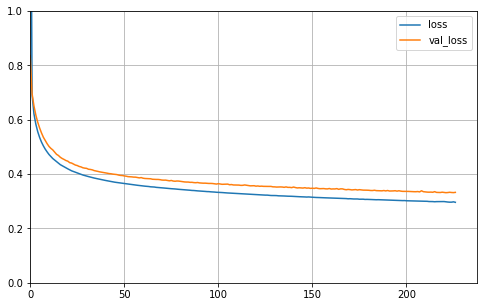

In [10]:
# Graph metrics over epochs for baseline model
pd.DataFrame(base_model_fitted.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.gca().set_xlim(0)
plt.show()

In [11]:
# Evaluate Model Performance
baseline_mse_test = base_model.evaluate(X_test, y_test)

# Make some predictions (use existing records for this part)
X_new = X_test[:10]
y_pred = base_model.predict(X_new)
y_xnew = y_test[:10]

#Examine predictions and actuals side by side
np.concatenate((y_pred.reshape(-1,1),y_xnew.reshape(-1,1)), axis=1)

162/162 [==============================] - 0s 289us/step - loss: 0.3402


array([[2.87911606, 2.347     ],
       [0.55310947, 0.792     ],
       [1.62645507, 2.266     ],
       [2.50179267, 3.105     ],
       [3.45142317, 3.553     ],
       [4.38782597, 4.473     ],
       [2.53372121, 2.103     ],
       [1.09579253, 0.911     ],
       [3.92683125, 5.00001   ],
       [1.71597505, 1.611     ]])

### Wide and Deep Neural Network Model

In [12]:
# Code Source: Hands On Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurelien Geron
# Build Layers
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
wd_model = keras.models.Model(inputs=[input_], outputs=[output])

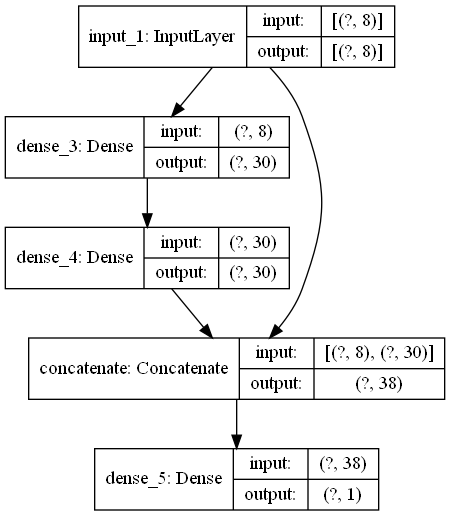

In [13]:
keras.utils.plot_model(wd_model, "../dot_models/CA_Housing_Wide_Deep.png", show_shapes=True)

In [14]:
#Compile wide and deep model
wd_model.compile(loss='mean_squared_error', optimizer = keras.optimizers.SGD(lr=0.001))

# Create checkpoint in case of unexpected interruptions
wd_cp = ModelCheckpoint("../saved_models/wd_ca_housing.h5")

# Fit wide and deep
wd_model_fitted = wd_model.fit(X_train, y_train, epochs=300, validation_data = (X_valid, y_valid),
                       callbacks=[EarlyStopping(patience=5, restore_best_weights=True), base_cp], verbose=0)

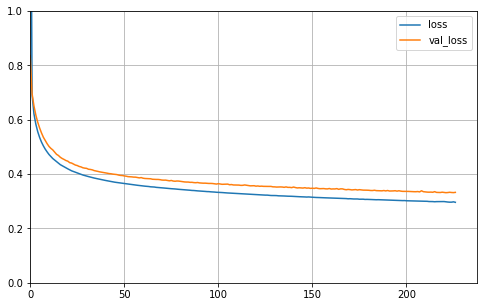

In [15]:
# Graph metrics over epochs for the wide and deep model
pd.DataFrame(base_model_fitted.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.gca().set_xlim(0)
plt.show()

In [16]:
# Evaluate Model Performance
wd_mse_test = wd_model.evaluate(X_test, y_test)

# Make some predictions (use existing records for this part)
X_new = X_test[:10]
y_pred = wd_model.predict(X_new)
y_xnew = y_test[:10]

#Examine predictions and actuals side by side
np.concatenate((y_pred.reshape(-1,1),y_xnew.reshape(-1,1)), axis=1)

## Baseline Model Performs Better

162/162 [==============================] - 0s 296us/step - loss: 0.3154


array([[2.78861833, 2.347     ],
       [0.51415485, 0.792     ],
       [1.66743898, 2.266     ],
       [2.601089  , 3.105     ],
       [3.39107823, 3.553     ],
       [4.46112776, 4.473     ],
       [2.50448823, 2.103     ],
       [0.9624508 , 0.911     ],
       [3.95437622, 5.00001   ],
       [1.82525945, 1.611     ]])

### Visualize with TensorBoard

In [18]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [19]:
run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2020_11_18-17_38_10'

In [20]:
keras.backend.clear_session()
notebook.list() # View open TensorBoard instances
# del /q %TMP%\.tensorboard-info\* in command line to stop instances
# notebook.display(port=6006, height=1000)

Known TensorBoard instances:
  - port 6006: logdir ./my_logs (started 0:02:52 ago; pid 7112)


In [21]:
### Use the baseline model
base_model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape = X_train.shape[1:]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

#Compile base model
base_model.compile(loss='mean_squared_error', optimizer = keras.optimizers.SGD(lr=0.005))

# Create checkpoint in case of unexpected interruptions
base_cp_tf = ModelCheckpoint("../saved_models/dense_ca_housing_baseline_tb.h5")

# Create the tensorboard callback
base_tensorboard = keras.callbacks.TensorBoard(run_logdir)

# Fit baseline model
base_model_fitted = base_model.fit(X_train, y_train, epochs=300, validation_data = (X_valid, y_valid),
                       callbacks=[EarlyStopping(patience=5, restore_best_weights=True), base_cp_tf,
                                 base_tensorboard],
                                   verbose=0)

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
